### Loading Required Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from matplotlib import pyplot as plt
from sklearn.metrics import (ConfusionMatrixDisplay, auc, brier_score_loss,
                             classification_report, confusion_matrix,
                             roc_auc_score, roc_curve)
from sklearn.utils import class_weight
from xgboost import XGBClassifier

In [2]:
RANDOM_SEED = 5654717
TEST_WEEK = 9
DATA_DIR = "data/ball_carrier_data.csv"

pd.options.display.max_columns = None

### Loading Data

In [3]:
data = pd.read_csv(DATA_DIR, encoding='utf-8')
player_play = pd.read_csv('data/player_play.csv')

In [4]:
# Merge the data tables
df = data.merge(player_play, on=['gameId', 'playId', 'nflId'], how='inner')

# Use vectorized conditions to create the 'role' column
role_conditions = [(~df['blockedPlayerNFLId1'].isna()) & (df['wasTargettedReceiver']==0) & (df['hadRushAttempt']==0)]
role_choices = [1]

df['isBlocker'] = np.select(role_conditions, role_choices, default=0)  # Default for cases not meeting any condition

In [5]:
features = [
    'voronoi_area', 'distance_to_qb', 'distance_to_ball', 'defender_influence',
    'teammate_influence', 'defender_awareness', 'teammate_awareness',
    'qb_awareness', 'closest_defender_awareness', 'second_closest_defender_awareness', 
    'closest_teammate_awareness', 'second_closest_teammate_awareness', 
    'closest_defender_distance', 'second_closest_defender_distance', 
    'closest_defender_speed', 'second_closest_defender_speed', 
    'closest_teammate_distance', 'second_closest_teammate_distance', 
    'closest_teammate_speed', 'second_closest_teammate_speed', 'player_speed',
    'relative_x_speed_to_closest_defender', 'relative_x_speed_to_second_closest_defender',
    'relative_y_speed_to_closest_defender', 'relative_y_speed_to_second_closest_defender',
    'relative_x_speed_to_closest_teammate', 'relative_x_speed_to_second_closest_teammate',
    'relative_y_speed_to_closest_teammate', 'relative_y_speed_to_second_closest_teammate', 
    'distance_to_los', 'y_position',
    ]
target = 'isBlocker'

In [6]:
training_data = df[(df.week != TEST_WEEK)]
testing_data = df[(df.week == TEST_WEEK)]

X_train, y_train = training_data[features], training_data[target]
X_test, y_test = testing_data[features], testing_data[target]

In [7]:
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

### Scoring Function

In [8]:
def score_model(y_true, y_pred, y_prob):
    print(f'ROC AUC Score: {roc_auc_score(y_true=y_true, y_score=y_prob)}')
    print(f"Brier Score: {brier_score_loss(y_true=y_true, y_prob=y_prob)}")
    print('-'*20)
    print(f"Brier Score for Negative: {brier_score_loss(y_true=y_true[y_true==0], y_prob=y_prob[y_true==0])}")
    print(f"Brier Score for Positive: {brier_score_loss(y_true=y_true[y_true==1], y_prob=y_prob[y_true==1])}")
    print('-'*20)
    print(classification_report(y_true=y_true, y_pred=y_pred))
    print('-'*20)
    print("Confusion Matrix:")
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

### XGBoost Classifier

ROC AUC Score: 0.9223434814616314
Brier Score: 0.11743924602725839
--------------------
Brier Score for Negative: 0.12821869805771072
Brier Score for Positive: 0.08900707923083055
--------------------


c:\Users\Simeel\NFL-Data-Bowl-2025\.venv\Lib\site-packages\sklearn\metrics\_classification.py:3239: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
c:\Users\Simeel\NFL-Data-Bowl-2025\.venv\Lib\site-packages\sklearn\metrics\_classification.py:3239: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
c:\Users\Simeel\NFL-Data-Bowl-2025\.venv\Lib\site-packages\sklearn\metrics\_classification.py:3239: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.95      0.79      0.87    420617
           1       0.62      0.90      0.74    159468

    accuracy                           0.82    580085
   macro avg       0.79      0.85      0.80    580085
weighted avg       0.86      0.82      0.83    580085

--------------------
Confusion Matrix:


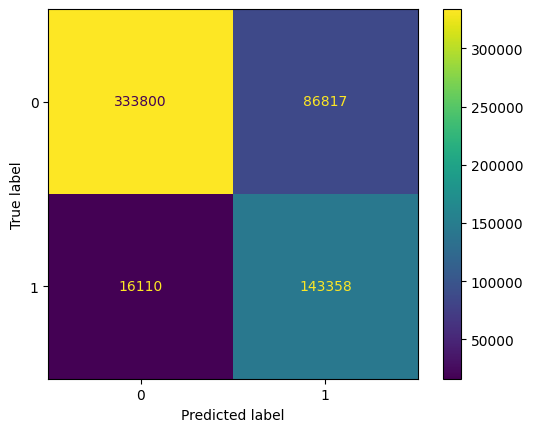

In [9]:
params = {
    "n_estimators": 750,
    "gamma": 1,
    "learning_rate": 0.1,
    "reg_lambda": 10,
    "eta": 0.5,
    "subsample": 0.75,
    "max_depth": 5
}

xgb_classifier = XGBClassifier(random_state=RANDOM_SEED, **params)
xgb_classifier.fit(X_train, y_train, sample_weight=classes_weights)

y_pred_xgb = xgb_classifier.predict(X_test)
y_probs_xgb = xgb_classifier.predict_proba(X_test)

score_model(y_pred=y_pred_xgb, y_true=y_test, y_prob=y_probs_xgb[:, 1])

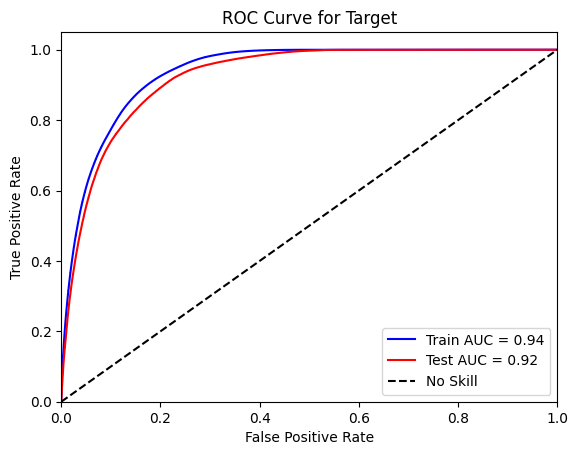

In [10]:
# Calculate ROC curve for train & test data
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, xgb_classifier.predict_proba(X_train)[:, 1]) 
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_probs_xgb[:, 1])
roc_auc_test = auc(fpr_test, tpr_test)

# Plot the ROC curve
plt.figure()  
plt.plot(fpr_train, tpr_train, label='Train AUC = %0.2f' % roc_auc_train, color = 'blue')
plt.plot(fpr_test, tpr_test, label='Test AUC = %0.2f' % roc_auc_test, color = 'red')
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Target')
plt.legend()
plt.show()

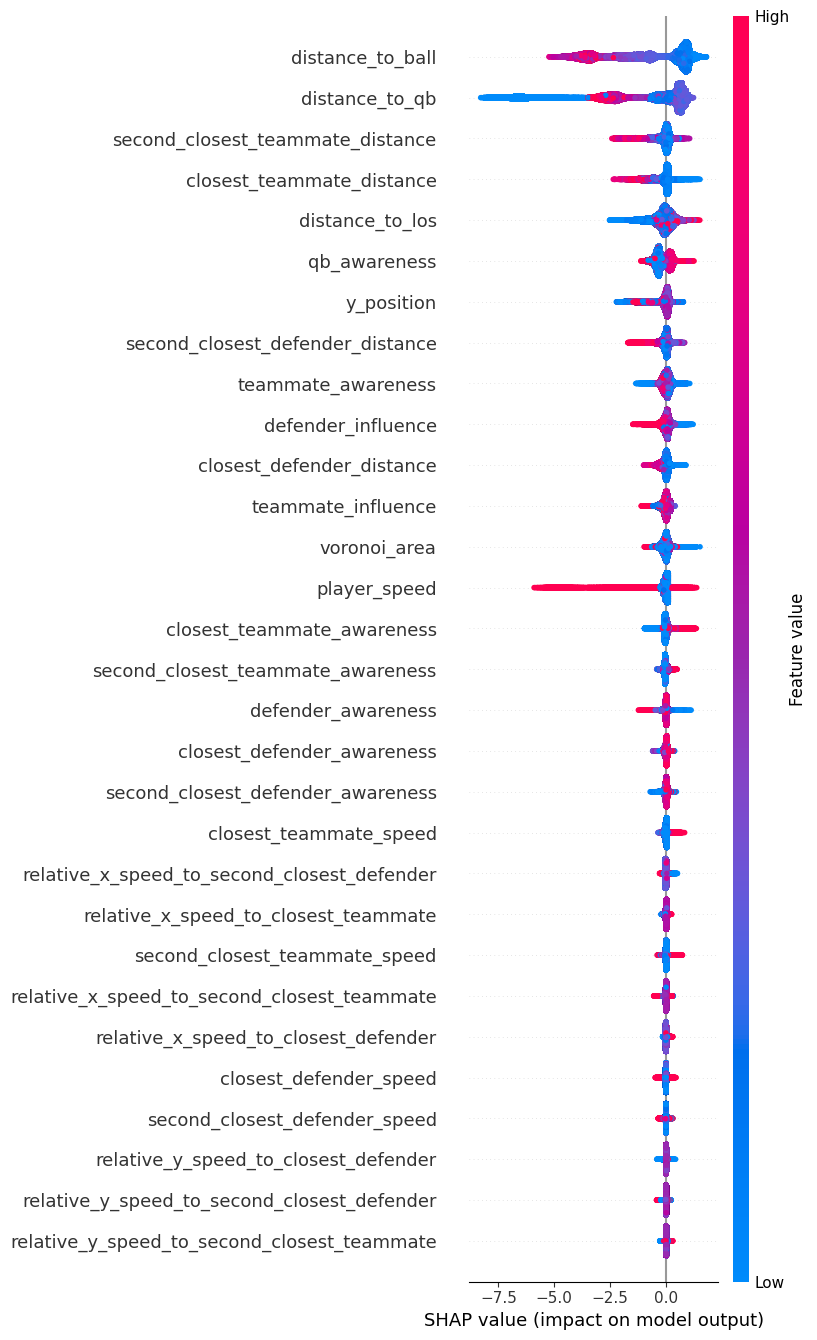

In [11]:
# Create an explainer object
explainer = shap.Explainer(xgb_classifier)

# Calculate SHAP values for a specific dataset
shap_values = explainer(X_test)

# Visualize SHAP values
shap.summary_plot(shap_values, X_test, max_display=30)

In [12]:
vals = np.abs(shap_values.values).mean(0)
feature_names = X_train.columns

feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                 columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],
                              ascending=False, inplace=True)
top_10_features = feature_importance.head(10).col_name.tolist()
feature_importance.head(10)

,col_name,feature_importance_vals
2,distance_to_ball,1.600519
1,distance_to_qb,1.529862
17,second_closest_teammate_distance,0.317186
16,closest_teammate_distance,0.307174
29,distance_to_los,0.304513
7,qb_awareness,0.282638
30,y_position,0.274472
13,second_closest_defender_distance,0.183789
6,teammate_awareness,0.129274
3,defender_influence,0.128020


ROC AUC Score: 0.9200897703810792
Brier Score: 0.12007519532588347
--------------------
Brier Score for Negative: 0.13266332391099186
Brier Score for Positive: 0.08687241557645067
--------------------


c:\Users\Simeel\NFL-Data-Bowl-2025\.venv\Lib\site-packages\sklearn\metrics\_classification.py:3239: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
c:\Users\Simeel\NFL-Data-Bowl-2025\.venv\Lib\site-packages\sklearn\metrics\_classification.py:3239: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
c:\Users\Simeel\NFL-Data-Bowl-2025\.venv\Lib\site-packages\sklearn\metrics\_classification.py:3239: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.96      0.78      0.86    420617
           1       0.61      0.91      0.73    159468

    accuracy                           0.82    580085
   macro avg       0.78      0.84      0.80    580085
weighted avg       0.86      0.82      0.82    580085

--------------------
Confusion Matrix:


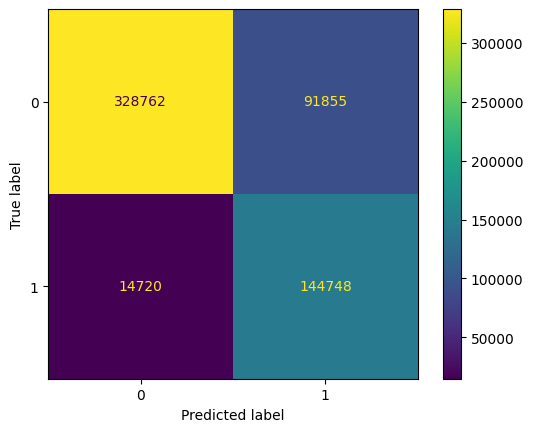

In [13]:
params = {
    "n_estimators": 750,
    "gamma": 10,
    "learning_rate": 0.1,
    "reg_lambda": 100,
    "eta": 0.3,
    "subsample": 0.5,
    "max_depth": 5
}

xgb_classifier_pruned = XGBClassifier(random_state=RANDOM_SEED, **params)
xgb_classifier_pruned.fit(X_train[top_10_features], y_train, sample_weight=classes_weights)

y_pred_xgb = xgb_classifier_pruned.predict(X_test[top_10_features])
y_probs_xgb = xgb_classifier_pruned.predict_proba(X_test[top_10_features])

score_model(y_pred=y_pred_xgb, y_true=y_test, y_prob=y_probs_xgb[:, 1])

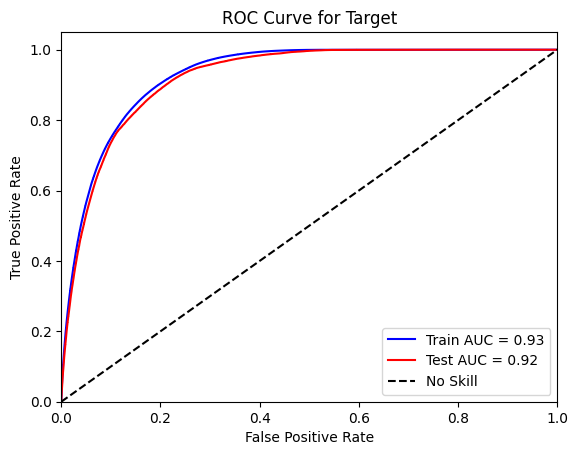

In [14]:
# Calculate ROC curve for train & test data
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, xgb_classifier_pruned.predict_proba(X_train[top_10_features])[:, 1]) 
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_probs_xgb[:, 1])
roc_auc_test = auc(fpr_test, tpr_test)

# Plot the ROC curve
plt.figure()  
plt.plot(fpr_train, tpr_train, label='Train AUC = %0.2f' % roc_auc_train, color = 'blue')
plt.plot(fpr_test, tpr_test, label='Test AUC = %0.2f' % roc_auc_test, color = 'red')
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Target')
plt.legend()
plt.show()

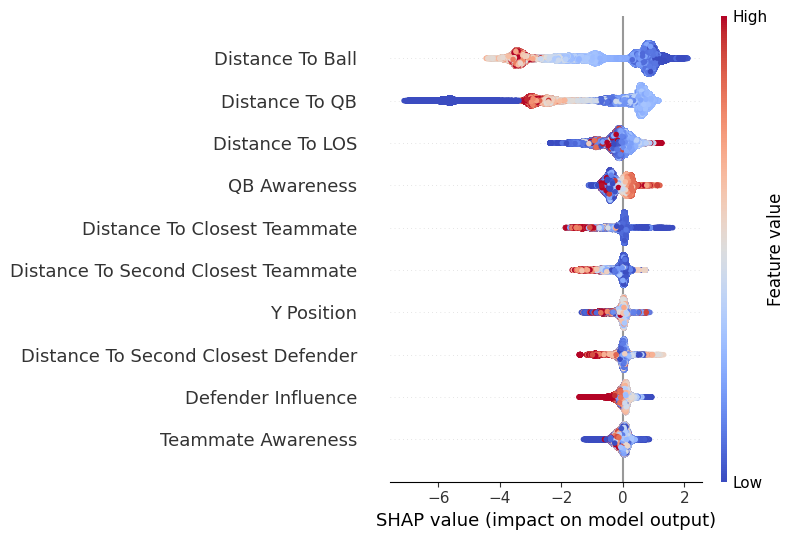

In [15]:
feature_names_cleaned = ['Distance To Ball', 'Distance To QB', 'Distance To Second Closest Teammate', 'Distance To Closest Teammate', 'Distance To LOS',  'QB Awareness', 'Y Position', 'Distance To Second Closest Defender', 'Teammate Awareness', 'Defender Influence']

# Create an explainer object
explainer = shap.Explainer(xgb_classifier_pruned)

# Calculate SHAP values for a specific dataset
shap_values = explainer(X_test[top_10_features])

# Visualize SHAP values
shap.summary_plot(shap_values, X_test[top_10_features], feature_names=feature_names_cleaned, max_display=10, cmap='coolwarm')

In [16]:
# Save XGB model
xgb_classifier_pruned.save_model("models/blocker_predictor.json")